In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn import preprocessing, model_selection, metrics
import lightgbm as lgb

color = sns.color_palette()
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

pd.options.mode.chained_assignment=None
pd.options.display.max_columns=9999

seed=79

In [7]:
data = pd.read_csv('energydata_complete.csv')
data.describe()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
count,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000
mean,97.694958,3.801875,21.686571,40.259739,20.341219,40.420420,22.267611,39.242500,20.855335,39.026904,19.592106,50.949283,7.910939,54.609083,20.267106,35.388200,22.029107,42.936165,19.485828,41.552401,7.411665,755.522602,79.750418,4.039752,38.330834,3.760707,24.988033,24.988033
std,102.524891,7.935988,1.606066,3.979299,2.192974,4.069813,2.006111,3.254576,2.042884,4.341321,1.844623,9.022034,6.090347,31.149806,2.109993,5.114208,1.956162,5.224361,2.014712,4.151497,5.317409,7.399441,14.901088,2.451221,11.794719,4.194648,14.496634,14.496634
min,10.000000,0.000000,16.790000,27.023333,16.100000,20.463333,17.200000,28.766667,15.100000,27.660000,15.330000,29.815000,-6.065000,1.000000,15.390000,23.200000,16.306667,29.600000,14.890000,29.166667,-5.000000,729.300000,24.000000,0.000000,1.000000,-6.600000,0.005322,0.005322
25%,50.000000,0.000000,20.760000,37.333333,18.790000,37.900000,20.790000,36.900000,19.530000,35.530000,18.277500,45.400000,3.626667,30.025000,18.700000,31.500000,20.790000,39.066667,18.000000,38.500000,3.666667,750.933333,70.333333,2.000000,29.000000,0.900000,12.497889,12.497889
50%,60.000000,0.000000,21.600000,39.656667,20.000000,40.500000,22.100000,38.530000,20.666667,38.400000,19.390000,49.090000,7.300000,55.290000,20.033333,34.863333,22.100000,42.375000,19.390000,40.900000,6.916667,756.100000,83.666667,3.666667,40.000000,3.433333,24.897653,24.897653
75%,100.000000,0.000000,22.600000,43.066667,21.500000,43.260000,23.290000,41.760000,22.100000,42.156667,20.619643,53.663333,11.256000,83.226667,21.600000,39.000000,23.390000,46.536000,20.600000,44.338095,10.408333,760.933333,91.666667,5.500000,40.000000,6.566667,37.583769,37.583769
max,1080.000000,70.000000,26.260000,63.360000,29.856667,56.026667,29.236000,50.163333,26.200000,51.090000,25.795000,96.321667,28.290000,99.900000,26.000000,51.400000,27.230000,58.780000,24.500000,53.326667,26.100000,772.300000,100.000000,14.000000,66.000000,15.500000,49.996530,49.996530


In [8]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data,test_size=0.25,random_state=seed)

In [9]:
train.describe()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
count,14801.000000,14801.000000,14801.000000,14801.000000,14801.000000,14801.000000,14801.000000,14801.000000,14801.000000,14801.000000,14801.000000,14801.000000,14801.000000,14801.000000,14801.000000,14801.000000,14801.000000,14801.000000,14801.000000,14801.000000,14801.000000,14801.000000,14801.000000,14801.000000,14801.000000,14801.000000,14801.000000,14801.000000
mean,97.875144,3.853118,21.691343,40.267556,20.344518,40.434363,22.278802,39.243995,20.860393,39.043799,19.604773,51.014065,7.923216,54.615000,20.273236,35.410874,22.028122,42.948244,19.493479,41.556594,7.421836,755.480135,79.824197,4.029001,38.290284,3.782509,24.893132,24.893132
std,102.314986,7.962567,1.615790,3.974692,2.202481,4.052420,2.012934,3.245701,2.048076,4.333479,1.849641,9.107390,6.117495,31.160835,2.118416,5.097243,1.960985,5.210450,2.022560,4.161295,5.343737,7.389218,14.901776,2.448171,11.789650,4.194994,14.539772,14.539772
min,10.000000,0.000000,16.790000,27.023333,16.100000,20.596667,17.200000,28.766667,15.100000,27.660000,15.340000,29.815000,-6.065000,1.000000,15.390000,23.260000,16.306667,29.600000,14.890000,29.166667,-5.000000,729.300000,24.000000,0.000000,1.000000,-6.600000,0.006033,0.006033
25%,50.000000,0.000000,20.760000,37.363333,18.790000,37.900000,20.790000,36.900000,19.533333,35.560000,18.290000,45.433333,3.626667,29.996667,18.700000,31.500000,20.790000,39.096667,18.000000,38.530000,3.666667,750.900000,70.500000,2.000000,29.000000,0.933333,12.352580,12.352580
50%,60.000000,0.000000,21.600000,39.693333,20.000000,40.500000,22.100000,38.560000,20.666667,38.433333,19.390000,49.096000,7.300000,55.267500,20.075000,34.900000,22.111111,42.390000,19.390000,40.900000,6.933333,756.000000,83.833333,3.666667,40.000000,3.483333,24.878409,24.878409
75%,100.000000,0.000000,22.633333,43.066667,21.500000,43.273453,23.340000,41.730000,22.100000,42.200000,20.653889,53.773333,11.226667,83.226667,21.600000,39.000000,23.390000,46.500000,20.600000,44.326667,10.433333,760.833333,91.666667,5.500000,40.000000,6.600000,37.534894,37.534894
max,1080.000000,60.000000,26.260000,63.360000,29.856667,54.766667,29.236000,50.163333,26.200000,51.090000,25.795000,96.321667,28.290000,99.900000,26.000000,51.327778,27.230000,58.780000,24.500000,53.326667,26.100000,772.300000,100.000000,14.000000,66.000000,15.316667,49.996530,49.996530


In [10]:
test.describe()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
count,4934.000000,4934.000000,4934.000000,4934.000000,4934.000000,4934.000000,4934.000000,4934.000000,4934.000000,4934.000000,4934.000000,4934.000000,4934.000000,4934.000000,4934.000000,4934.000000,4934.000000,4934.000000,4934.000000,4934.000000,4934.000000,4934.000000,4934.000000,4934.000000,4934.000000,4934.000000,4934.000000,4934.000000
mean,97.154439,3.648156,21.672257,40.236290,20.331323,40.378596,22.234041,39.238015,20.840160,38.976220,19.554108,50.754948,7.874112,54.591333,20.248718,35.320184,22.032060,42.899931,19.462877,41.539823,7.381154,755.649993,79.529097,4.072001,38.452473,3.695305,25.272720,25.272720
std,103.160524,7.854510,1.576610,3.993397,2.164393,4.121677,1.985326,3.281383,2.027363,4.364807,1.829148,8.759030,6.008635,31.119847,2.084626,5.164687,1.941816,5.266233,1.991014,4.122361,5.238054,7.429316,14.898340,2.460314,11.810271,4.193354,14.364154,14.364154
min,10.000000,0.000000,16.823333,27.233333,16.100000,20.463333,17.200000,30.563333,15.100000,28.135714,15.330000,30.956667,-5.872222,1.000000,15.390000,23.200000,16.373333,29.700000,14.890000,29.166667,-4.944444,729.433333,25.500000,0.000000,1.000000,-6.450000,0.005322,0.005322
25%,50.000000,0.000000,20.730000,37.290000,18.856667,37.860833,20.790000,36.863333,19.500000,35.466667,18.200000,45.326667,3.663333,30.160833,18.700000,31.357500,20.812222,38.930833,18.005000,38.500000,3.666667,751.000000,70.000000,2.000000,29.000000,0.850000,12.887871,12.887871
50%,60.000000,0.000000,21.600000,39.565000,19.933571,40.421667,22.100000,38.500000,20.600000,38.313333,19.290000,49.000000,7.230000,55.290000,20.000000,34.790000,22.100000,42.360000,19.390000,40.817500,6.900000,756.200000,83.500000,3.666667,40.000000,3.366667,25.066420,25.066420
75%,100.000000,0.000000,22.600000,43.090000,21.500000,43.228929,23.290000,41.790000,22.100000,42.090000,20.600000,53.363333,11.300000,83.182500,21.600000,39.082500,23.390000,46.623611,20.533333,44.362500,10.345833,761.191667,91.166667,5.666667,40.000000,6.400000,37.771965,37.771965
max,1070.000000,70.000000,26.166667,57.496667,29.856667,56.026667,28.956000,49.800000,26.142857,50.860000,25.745000,94.836111,27.921429,99.900000,25.890000,51.400000,27.200000,58.675556,24.500000,53.090000,25.816667,772.266667,100.000000,13.000000,65.000000,15.500000,49.981667,49.981667


In [11]:
temp_cols = ["T1","T2","T3","T4","T5","T6","T7","T8","T9"]

#humidity sensor columns
rho_cols = ["RH_1","RH_2","RH_3","RH_4","RH_5","RH_6","RH_7","RH_8","RH_9"]

#weather data
weather_cols = ["T_out", "Tdewpoint","RH_out","Press_mm_hg","Windspeed","Visibility"]

target = ["Appliances"]

In [12]:
output = train[target]
input_vars = train[temp_cols + rho_cols + weather_cols]

In [14]:
input_vars.describe()

,T1,T2,T3,T4,T5,T6,T7,T8,T9,RH_1,RH_2,RH_3,RH_4,RH_5,RH_6,RH_7,RH_8,RH_9,T_out,Tdewpoint,RH_out,Press_mm_hg,Windspeed,Visibility
count,14801.000000,14801.000000,14801.000000,14801.000000,14801.000000,14801.000000,14801.000000,14801.000000,14801.000000,14801.000000,14801.000000,14801.000000,14801.000000,14801.000000,14801.000000,14801.000000,14801.000000,14801.000000,14801.000000,14801.000000,14801.000000,14801.000000,14801.000000,14801.000000
mean,21.691343,20.344518,22.278802,20.860393,19.604773,7.923216,20.273236,22.028122,19.493479,40.267556,40.434363,39.243995,39.043799,51.014065,54.615000,35.410874,42.948244,41.556594,7.421836,3.782509,79.824197,755.480135,4.029001,38.290284
std,1.615790,2.202481,2.012934,2.048076,1.849641,6.117495,2.118416,1.960985,2.022560,3.974692,4.052420,3.245701,4.333479,9.107390,31.160835,5.097243,5.210450,4.161295,5.343737,4.194994,14.901776,7.389218,2.448171,11.789650
min,16.790000,16.100000,17.200000,15.100000,15.340000,-6.065000,15.390000,16.306667,14.890000,27.023333,20.596667,28.766667,27.660000,29.815000,1.000000,23.260000,29.600000,29.166667,-5.000000,-6.600000,24.000000,729.300000,0.000000,1.000000
25%,20.760000,18.790000,20.790000,19.533333,18.290000,3.626667,18.700000,20.790000,18.000000,37.363333,37.900000,36.900000,35.560000,45.433333,29.996667,31.500000,39.096667,38.530000,3.666667,0.933333,70.500000,750.900000,2.000000,29.000000
50%,21.600000,20.000000,22.100000,20.666667,19.390000,7.300000,20.075000,22.111111,19.390000,39.693333,40.500000,38.560000,38.433333,49.096000,55.267500,34.900000,42.390000,40.900000,6.933333,3.483333,83.833333,756.000000,3.666667,40.000000
75%,22.633333,21.500000,23.340000,22.100000,20.653889,11.226667,21.600000,23.390000,20.600000,43.066667,43.273453,41.730000,42.200000,53.773333,83.226667,39.000000,46.500000,44.326667,10.433333,6.600000,91.666667,760.833333,5.500000,40.000000
max,26.260000,29.856667,29.236000,26.200000,25.795000,28.290000,26.000000,27.230000,24.500000,63.360000,54.766667,50.163333,51.090000,96.321667,99.900000,51.327778,58.780000,53.326667,26.100000,15.316667,100.000000,772.300000,14.000000,66.000000


In [15]:
output.values

array([[ 70],
       [ 40],
       [ 70],
       ...,
       [ 60],
       [100],
       [ 50]])

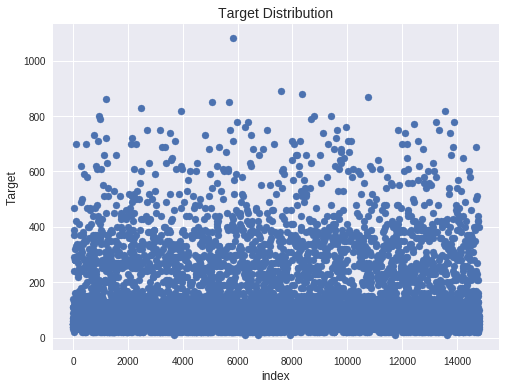

In [16]:
plt.figure(figsize=(8,6))
plt.scatter(range(output.shape[0]), np.sort(output.values))
plt.xlabel('index',fontsize=12)
plt.ylabel('Target', fontsize=12)
plt.title("Target Distribution", fontsize=14)
plt.show()

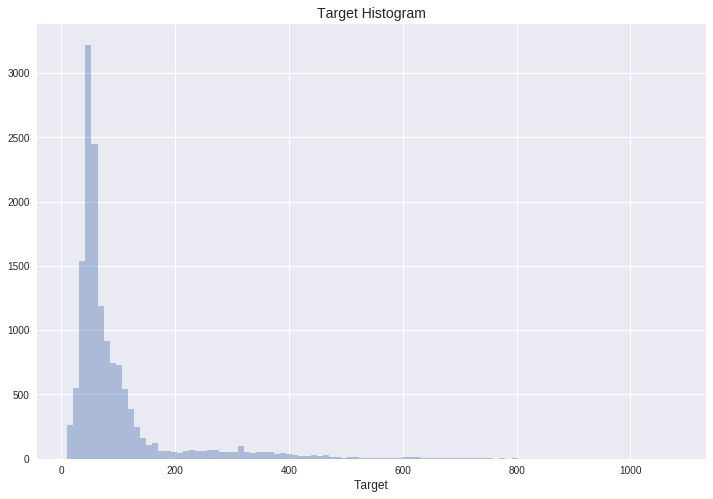

In [17]:
plt.figure(figsize=(12,8))
sns.distplot(output.values, bins=100, kde=False)
plt.xlabel('Target',fontsize=12)
plt.title('Target Histogram', fontsize=14)
plt.show()

In [18]:
missing_df = input_vars.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')
missing_df

,column_name,missing_count


In [19]:
dtype_df = input_vars.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df.groupby("Column Type").aggregate('count').reset_index()

,Column Type,Count
0,float64,24


In [20]:
unique_df = input_vars.nunique().reset_index()
unique_df.columns = ['col_name','unique_count']
constant_df = unique_df[unique_df['unique_count']==1]
constant_df.shape

(0, 2)

In [21]:
from scipy.stats import spearmanr
import warnings
warnings.filterwarnings('ignore')

In [22]:
labels = []
values = []
for col in input_vars.columns:
    labels.append(col)
    values.append(spearmanr(input_vars[col].values, output.values)[0])

In [23]:
corr_df = pd.DataFrame({'col_labels':labels, 'corr_values':values})
corr_df = corr_df.sort_values(by='corr_values')

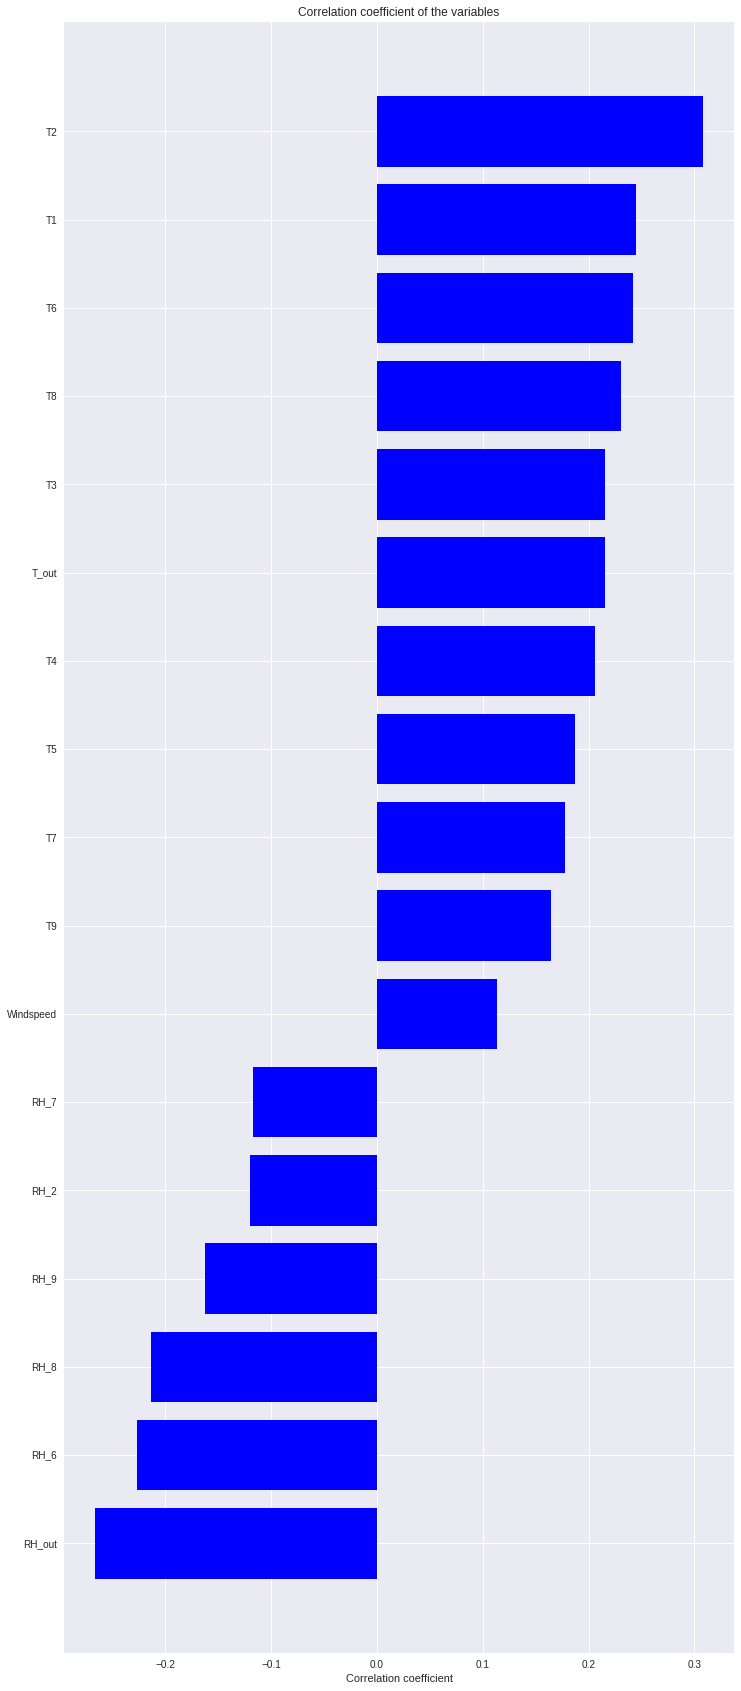

In [24]:
corr_df = corr_df[(corr_df['corr_values']>0.1) | (corr_df['corr_values']<-0.1)]
ind = np.arange(corr_df.shape[0])
width = 0.9
fig,ax = plt.subplots(figsize=(12,30))
rects = ax.barh(ind, np.array(corr_df.corr_values.values), color='b')
ax.set_yticks(ind)
ax.set_yticklabels(corr_df.col_labels.values, rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation coefficient of the variables")
plt.show()

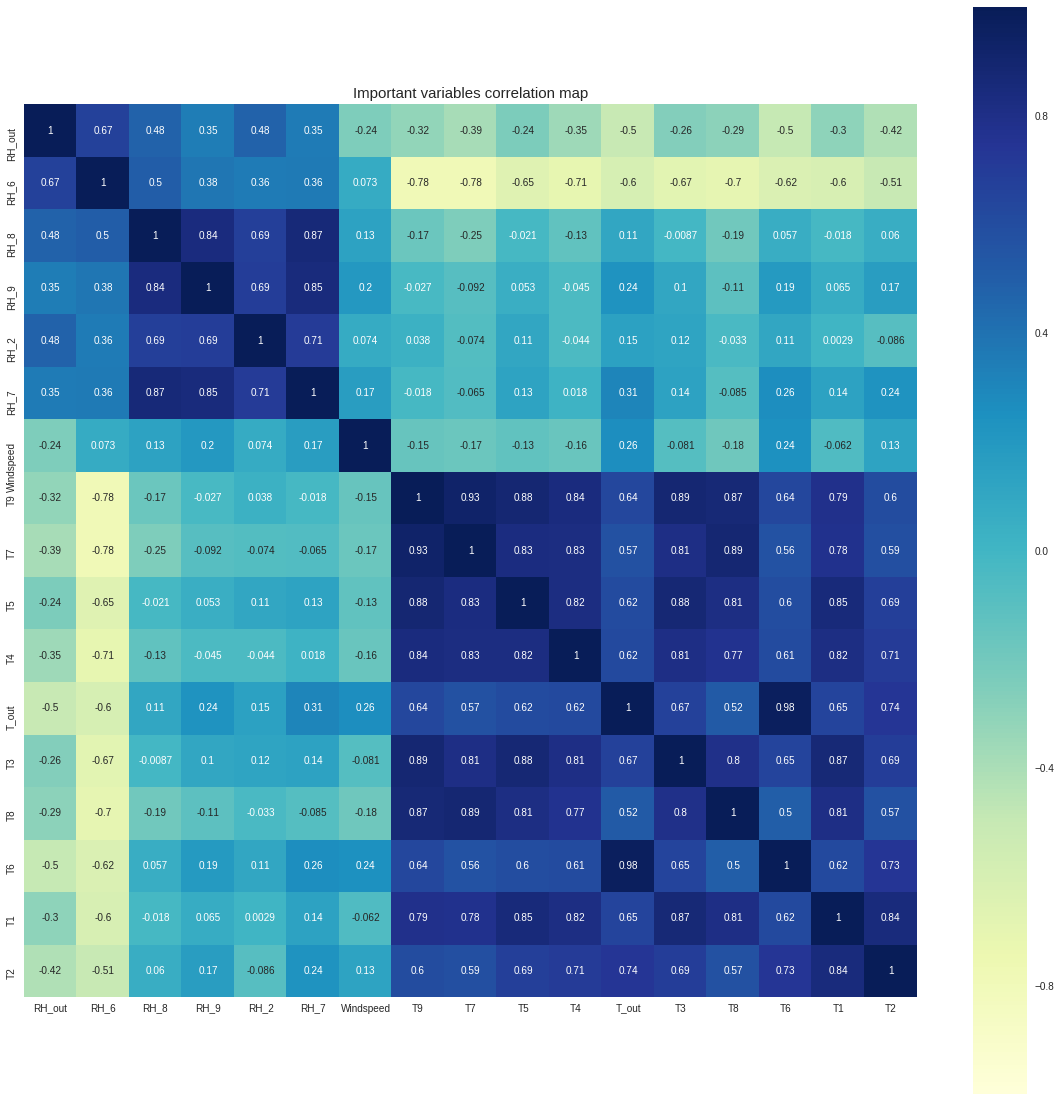

In [26]:
cols_to_use = corr_df[(corr_df['corr_values']>0.11) | (corr_df['corr_values']<-0.11)].col_labels.tolist()

temp_df = train[cols_to_use]
corrmat = temp_df.corr(method='spearman')
f,ax = plt.subplots(figsize=(20,20))

sns.heatmap(corrmat, vmax=1., square=True, cmap = 'YlGnBu', annot=True)
plt.title("Important variables correlation map", fontsize=15)
plt.show()

In [27]:
train_X  = input_vars.drop(constant_df.col_name.tolist(), axis=1)
#test_X = test_df.drop(constant_df.col_name.tolist() + ["ID"], axis=1)
train_y = output.values

In [28]:
from sklearn import ensemble
model = ensemble.ExtraTreesRegressor(n_estimators=200, max_depth=20, max_features=0.5, n_jobs=-1, random_state=0)
model.fit(train_X, train_y)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=20,
          max_features=0.5, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
          oob_score=False, random_state=0, verbose=0, warm_start=False)

In [29]:
feature_names = train_X.columns.values
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1][:20]

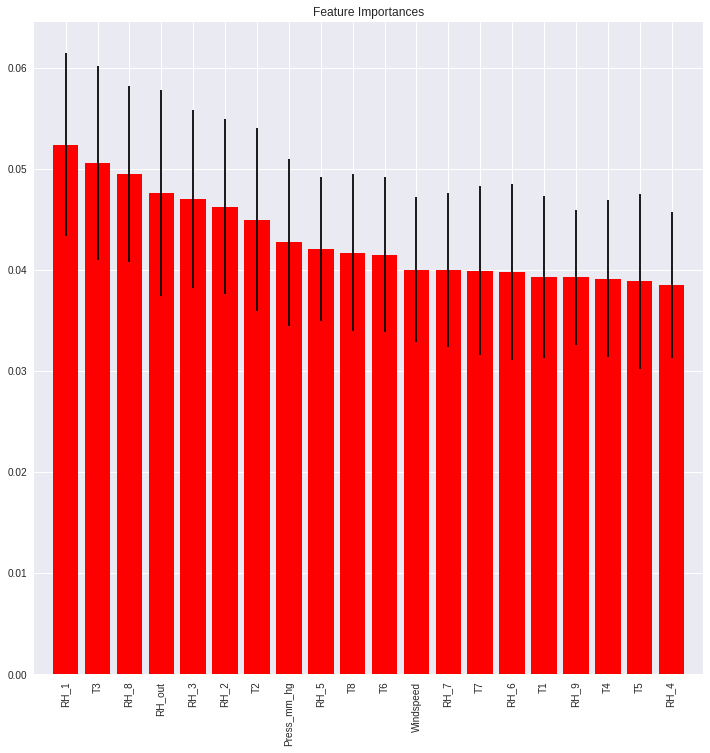

In [30]:
plt.figure(figsize=(12,12))
plt.title("Feature Importances")
plt.bar(range(len(indices)), importances[indices], color='r', yerr=std[indices], align="center")
plt.xticks(range(len(indices)), feature_names[indices], rotation='vertical')
plt.xlim([-1, len(indices)])
plt.show()

In [31]:
from sklearn.linear_model import LinearRegression

In [32]:
X_train = input_vars
y_train = output

In [33]:
benchmark_model = LinearRegression()
benchmark_model.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [35]:
X_test = test[temp_cols + rho_cols + weather_cols]
y_test = test[target]

In [37]:
benchmark_model.score(X_train,y_train)

0.14687323003859143

In [38]:
benchmark_model.score(X_test,y_test)

0.1425787010467039

In [39]:
train = X_train.join(y_train)
test = X_test.join(y_test)

In [40]:
from sklearn.preprocessing import StandardScaler

In [41]:
standard_scaler = StandardScaler()

train_scaled = pd.DataFrame(columns=train.columns, index=train.index)
test_scaled = pd.DataFrame(columns=test.columns, index=test.index)

train_scaled[train_scaled.columns] = standard_scaler.fit_transform(train)
test_scaled[test_scaled.columns] = standard_scaler.fit_transform(test)

In [42]:
X_train = train_scaled.drop("Appliances", axis=1)
y_train = train_scaled["Appliances"]

X_test = test_scaled.drop("Appliances", axis=1)
y_test = test_scaled["Appliances"]

In [43]:
from sklearn.metrics import mean_squared_error

def pipeline(reg, X_train, y_train, X_test, y_test, **kwargs):
    reg_props = {}
    
    regressor = reg(**kwargs)
    regressor.fit(X_train, y_train)
    
    reg_props["name"] = reg.__name__
    reg_props["train_score"] = regressor.score(X_train, y_train)
    reg_props["test_score"] = regressor.score(X_test, y_test)
    reg_props["rmse"] = np.sqrt(mean_squared_error(y_test, regressor.predict(X_test)))
    
    return reg_props

In [44]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.neural_network import MLPRegressor

In [45]:
def execute_pipeline():
    regressors = [
        Ridge, 
        Lasso,
        RandomForestRegressor,
        ExtraTreesRegressor,
        MLPRegressor
    ]
    
    props = []
    
    for reg in regressors:
        properties = pipeline( reg, X_train, y_train, X_test, y_test, random_state=seed)
        props.append(properties)
        
    return props


In [46]:
def get_properties():
    properties = execute_pipeline()
    
    names = [prop['name'] for prop in properties]
    train_scores = [prop['train_score'] for prop in properties]
    test_scores = [prop['test_score'] for prop in properties]
    rmse_vals = [prop['rmse'] for prop in properties]
    
    df = pd.DataFrame( index=names,
                      data={
                          "Training scores" : train_scores,
                          "Testing scores" : test_scores,
                          "RMSE" :rmse_vals
                      })
    return df

In [47]:
properties = get_properties()


In [48]:
benchmark_model.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [49]:
properties = pd.concat([properties, pd.Series({
    "RMSE":np.sqrt(mean_squared_error(y_test, benchmark_model.predict(X_test))),
    "Training scores": benchmark_model.score(X_train,y_train),
    "Testing scores" : benchmark_model.score(X_test,y_test),
    "Name": "Linear Regression"
}).to_frame().T.set_index(["Name"])]
                    )

In [50]:
properties

,RMSE,Testing scores,Training scores
Ridge,0.926034,0.142462,0.146872
Lasso,1,0,0
RandomForestRegressor,0.731369,0.4651,0.91252
ExtraTreesRegressor,0.647609,0.580603,1
MLPRegressor,0.843244,0.28894,0.367614
Linear Regression,0.926026,0.142476,0.146873


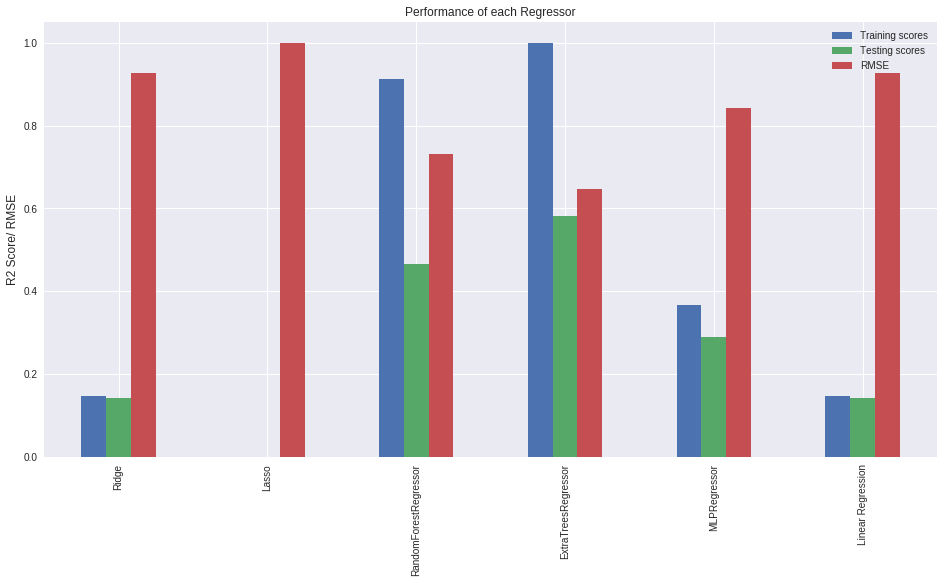

In [51]:
ax= properties[["Training scores", "Testing scores", "RMSE"]].plot(kind="bar", title="Performance of each Regressor", figsize=(16, 8))
ax.set_ylabel("R2 Score/ RMSE", fontsize="large")

# Least  - LASSO<br>
# Best  - Extra Trees